In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import xgboost as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=2

In [3]:
print FOLD

2


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",with_l2=True,with_l3=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

0

# cv

In [9]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [10]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [11]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [12]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                                                            ,
                    'l2_3000_ridge_fold{}_False_d478.pkl', 'l2_3003_conv_fold{}_False_d478.pkl', 'l2_3001_lgb_fold{}_False_d478.pkl', 'l2_3006_xgb_fold{}_False_d478.pkl'                   
                    
                   ])

In [13]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [14]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [15]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [16]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [17]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,max_depth=4,subsample=1,C=0.1,
                                    learning_rate=0.02,min_child_weight=1,objective='reg:l1f0',
                                     gamma=0,reg_alpha=0,reg_lambda=1 ):
        models=[]
        scores=[]
        d_train = lgb.DMatrix(trainX, label=trainy)
        d_valid = lgb.DMatrix(validX, label=validy)
        
        if 1:
            params = {}
            params['eta'] = learning_rate
            params['objective'] = objective
            params['eval_metric'] = 'rmse'
            params['max_depth'] = max_depth
            params['colsample_bytree'] = colsample_bytree
            params['subsample'] = subsample
            params['min_child_weight'] = min_child_weight 
            params['gamma'] = gamma            
            params['reg_alpha'] = reg_alpha            
            params['reg_lambda'] = reg_lambda            
            params['silent'] = 1
            params['nthread'] = 8
            params['tree_method']='hist'
            print i, params
            watchlist = [(d_train, 'train'), (d_valid, 'valid')]
            
            gbm = lgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50, verbose_eval=50)


            models.append(gbm)
            validpred=gbm.predict(d_valid,ntree_limit=gbm.best_ntree_limit)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(d_train,ntree_limit=gbm.best_ntree_limit)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [18]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [19]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    d_test = lgb.DMatrix(testX, label=testy)    
    test_pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        d_test = lgb.DMatrix(X)    
        pred=model.predict(d_test,ntree_limit=model.best_ntree_limit).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    d_test = lgb.DMatrix(X)    
    pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)

    return pred,dataidx


In [20]:
parameter={'colsample_bytree': 0.5,
 'learning_rate': 0.02,
 'max_depth': 8,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'subsample': 1}

In [21]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [22]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [23]:
def ff(offset):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    #validpreds[offset]=[validpred,pred478]
    return offset, [validpred,pred478]
    #pickle.dump(validpreds, open('3005_rf_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [24]:
j=FOLD
validpreds={}

In [25]:
p = Pool(1,maxtasksperchild=1)



1
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1571
0
(201158, 1, 32) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 256) (201158,) (201158,)
(49582, 1, 32) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 256) (49582,) (49582,)
(5803, 1, 32) (5803, 7, 32) (5803, 1) (5803, 1)
(5803, 256) (5803,) (5803,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40134	valid-rmse:2.36334
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.986846	valid-rmse:0.975128
[100]	train-rmse:0.575733	valid-rmse:0.581711
[150]	train-rmse:0.49143	valid-rmse:0.508219
[200]	train-rmse:0.475325	valid-rmse:0.498131
[250]	train-rmse:0.469701	valid-rmse:0.497011
[300]	train-rmse:0.465687	valid-rmse:0.497003
Stopping. Best iteration:
[276]	train-rmse:0.467577	valid-rmse:0.496976

0.21862824 0.24698511
[0.24698511]
-1 mean score 0.24698511
0.195055797696


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913400  0.015710  0.209813    7  2017-04-16
472     2.507290  2.525121 -0.017831  0.205825    1  2017-04-17
473     2.661330  2.655221  0.006109  0.227060    2  2017-04-18
474     2.754815  2.737968  0.016846  0.189012    3  2017-04-19
475     2.713762  2.704168  0.009593  0.216850    4  2017-04-20
476     2.999000  2.980268  0.018731  0.143908    5  2017-04-21
477     3.075529  3.073776  0.001753  0.172923    6  2017-04-22

0.195055797696


pred         y     error    error2  day        date
dayidx                                                         
471     2.913400  2.929110  0.015710  0.209813    7  2017-04-16
472     2.525121  2.507290 -0.017831  0.205825    1  2017-04-17
473     2.655221  2.661330  0.006109  0.227060    2  2017-04-18
474     2.737968  2.754815  0.016846  0.189012    3  2017-04-19
475     2.704168  2.713762  0.009593  0.216850    4  2017-04-20
476     2.980268  2.999000  0.018731  0.143908    5  2017-04-21
477     3.073776  3.075529  0.001753  0.172923    6  2017-04-22

(829, 256)


In [26]:
results=p.map(ff, range(1,40),chunksize=1)



2
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200932, 2) (49525, 2)
train/valid # (200932, 2) (49525, 2)
rand split across time
train has 200932 records out of 389630 records
valid has 49525 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1569
0
(200932, 1, 32) (200932, 7, 32) (200932, 1) (200932, 1)
(200932, 256) (200932,) (200932,)
(49525, 1, 32) (49525, 7, 32) (49525, 1) (49525, 1)
(49525, 256) (49525,) (49525,)
(6632, 1, 32) (6632, 7, 32) (6632, 1) (6632, 1)
(6632, 256) (6632,) (6632,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40119	valid-rmse:2.36312
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.990369	valid-rmse:0.97843
[100]	train-rmse:0.580906	valid-rmse:0.588084
[150]	train-rmse:0.496274	valid-rmse:0.51538
[200]	train-rmse:0.479407	valid-rmse:0.505118
[250]	train-rmse:0.473141	valid-rmse:0.503836
[300]	train-rmse:0.468535	valid-rmse:0.503699
[350]	train-rmse:0.465337	valid-rmse:0.503711
Stopping. Best iteration:
[319]	train-rmse:0.467266	valid-rmse:0.503686

0.21833733 0.25369993
[0.25369993]
-1 mean score 0.25369993
0.194601044059


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910835  0.018275  0.211050    7  2017-04-16
472     2.507290  2.537137 -0.029846  0.208487    1  2017-04-17
473     2.661330  2.657403  0.003926  0.224884    2  2017-04-18
474     2.754815  2.738332  0.016483  0.188871    3  2017-04-19
475     2.713762  2.713112  0.000650  0.215889    4  2017-04-20
476     2.999000  2.988650  0.010350  0.143268    5  2017-04-21
477     3.075529  3.069414  0.006115  0.169758    6  2017-04-22

0.194601044059


pred         y     error    error2  day        date
dayidx                                                         
471     2.910835  2.929110  0.018275  0.211050    7  2017-04-16
472     2.537137  2.507290 -0.029846  0.208487    1  2017-04-17
473     2.657403  2.661330  0.003926  0.224884    2  2017-04-18
474     2.738332  2.754815  0.016483  0.188871    3  2017-04-19
475     2.713112  2.713762  0.000650  0.215889    4  2017-04-20
476     2.988650  2.999000  0.010350  0.143268    5  2017-04-21
477     3.069414  3.075529  0.006115  0.169758    6  2017-04-22

(829, 256)


3
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200747, 2) (49483, 2)
train/valid # (200747, 2) (49483, 2)
rand split across time
train has 200747 records out of 389630 records
valid has 49483 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1568
0
(200747, 1, 32) (200747, 7, 32) (200747, 1) (200747, 1)
(200747, 256) (200747,) (200747,)
(49483, 1, 32) (49483, 7, 32) (49483, 1) (49483, 1)
(49483, 256) (49483,) (49483,)
(7461, 1, 32) (7461, 7, 32) (7461, 1) (7461, 1)
(7461, 256) (7461,) (7461,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40098	valid-rmse:2.36296
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.991421	valid-rmse:0.980896
[100]	train-rmse:0.582979	valid-rmse:0.590493
[150]	train-rmse:0.498833	valid-rmse:0.517069
[200]	train-rmse:0.48218	valid-rmse:0.506685
[250]	train-rmse:0.475867	valid-rmse:0.50533
[300]	train-rmse:0.471603	valid-rmse:0.50516
[350]	train-rmse:0.468257	valid-rmse:0.505061
Stopping. Best iteration:
[347]	train-rmse:0.468433	valid-rmse:0.505055

0.21942939 0.2550805
[0.2550805]
-1 mean score 0.2550805
0.198732107878


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898759  0.030351  0.215684    7  2017-04-16
472     2.507290  2.530200 -0.022909  0.210421    1  2017-04-17
473     2.661330  2.645521  0.015809  0.235986    2  2017-04-18
474     2.754815  2.756446 -0.001631  0.196951    3  2017-04-19
475     2.713762  2.710225  0.003536  0.214366    4  2017-04-20
476     2.999000  2.992572  0.006427  0.143280    5  2017-04-21
477     3.075529  3.072875  0.002654  0.174437    6  2017-04-22

0.198732107878


pred         y     error    error2  day        date
dayidx                                                         
471     2.898759  2.929110  0.030351  0.215684    7  2017-04-16
472     2.530200  2.507290 -0.022909  0.210421    1  2017-04-17
473     2.645521  2.661330  0.015809  0.235986    2  2017-04-18
474     2.756446  2.754815 -0.001631  0.196951    3  2017-04-19
475     2.710225  2.713762  0.003536  0.214366    4  2017-04-20
476     2.992572  2.999000  0.006427  0.143280    5  2017-04-21
477     3.072875  3.075529  0.002654  0.174437    6  2017-04-22

(829, 256)


4
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200584, 2) (49444, 2)
train/valid # (200584, 2) (49444, 2)
rand split across time
train has 200584 records out of 389630 records
valid has 49444 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1567
0
(200584, 1, 32) (200584, 7, 32) (200584, 1) (200584, 1)
(200584, 256) (200584,) (200584,)
(49444, 1, 32) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 256) (49444,) (49444,)
(8290, 1, 32) (8290, 7, 32) (8290, 1) (8290, 1)
(8290, 256) (8290,) (8290,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40101	valid-rmse:2.36304
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.992453	valid-rmse:0.982109
[100]	train-rmse:0.584434	valid-rmse:0.59247
[150]	train-rmse:0.500219	valid-rmse:0.519278
[200]	train-rmse:0.483336	valid-rmse:0.508748
[250]	train-rmse:0.476948	valid-rmse:0.507331
[300]	train-rmse:0.472528	valid-rmse:0.507081
[350]	train-rmse:0.468771	valid-rmse:0.507058
[400]	train-rmse:0.465625	valid-rmse:0.507025
Stopping. Best iteration:
[387]	train-rmse:0.466552	valid-rmse:0.507005

0.21767034 0.25705412
[0.25705412]
-1 mean score 0.25705412
0.195044025779


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901624  0.027486  0.214602    7  2017-04-16
472     2.507290  2.524132 -0.016841  0.208242    1  2017-04-17
473     2.661330  2.640154  0.021176  0.222694    2  2017-04-18
474     2.754815  2.737764  0.017051  0.191250    3  2017-04-19
475     2.713762  2.712011  0.001750  0.216448    4  2017-04-20
476     2.999000  2.981979  0.017021  0.144607    5  2017-04-21
477     3.075529  3.067819  0.007710  0.167464    6  2017-04-22

0.195044025779


pred         y     error    error2  day        date
dayidx                                                         
471     2.901624  2.929110  0.027486  0.214602    7  2017-04-16
472     2.524132  2.507290 -0.016841  0.208242    1  2017-04-17
473     2.640154  2.661330  0.021176  0.222694    2  2017-04-18
474     2.737764  2.754815  0.017051  0.191250    3  2017-04-19
475     2.712011  2.713762  0.001750  0.216448    4  2017-04-20
476     2.981979  2.999000  0.017021  0.144607    5  2017-04-21
477     3.067819  3.075529  0.007710  0.167464    6  2017-04-22

(829, 256)


5
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200384, 2) (49392, 2)
train/valid # (200384, 2) (49392, 2)
rand split across time
train has 200384 records out of 389630 records
valid has 49392 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1565
0
(200384, 1, 32) (200384, 7, 32) (200384, 1) (200384, 1)
(200384, 256) (200384,) (200384,)
(49392, 1, 32) (49392, 7, 32) (49392, 1) (49392, 1)
(49392, 256) (49392,) (49392,)
(9119, 1, 32) (9119, 7, 32) (9119, 1) (9119, 1)
(9119, 256) (9119,) (9119,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40125	valid-rmse:2.36314
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.993456	valid-rmse:0.982486
[100]	train-rmse:0.585711	valid-rmse:0.593595
[150]	train-rmse:0.50125	valid-rmse:0.520666
[200]	train-rmse:0.484446	valid-rmse:0.510441
[250]	train-rmse:0.4779	valid-rmse:0.509134
[300]	train-rmse:0.47361	valid-rmse:0.508903
[350]	train-rmse:0.47035	valid-rmse:0.508886
[400]	train-rmse:0.467055	valid-rmse:0.508839
[450]	train-rmse:0.464109	valid-rmse:0.508883
Stopping. Best iteration:
[408]	train-rmse:0.466651	valid-rmse:0.508824

0.2177628 0.25890228
[0.25890228]
-1 mean score 0.25890228
0.196398898959


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900941  0.028169  0.214856    7  2017-04-16
472     2.507290  2.531167 -0.023877  0.212376    1  2017-04-17
473     2.661330  2.630071  0.031259  0.227594    2  2017-04-18
474     2.754815  2.737220  0.017594  0.192386    3  2017-04-19
475     2.713762  2.709431  0.004331  0.214884    4  2017-04-20
476     2.999000  2.986581  0.012419  0.145740    5  2017-04-21
477     3.075529  3.072810  0.002719  0.166957    6  2017-04-22

0.196398898959


pred         y     error    error2  day        date
dayidx                                                         
471     2.900941  2.929110  0.028169  0.214856    7  2017-04-16
472     2.531167  2.507290 -0.023877  0.212376    1  2017-04-17
473     2.630071  2.661330  0.031259  0.227594    2  2017-04-18
474     2.737220  2.754815  0.017594  0.192386    3  2017-04-19
475     2.709431  2.713762  0.004331  0.214884    4  2017-04-20
476     2.986581  2.999000  0.012419  0.145740    5  2017-04-21
477     3.072810  3.075529  0.002719  0.166957    6  2017-04-22

(829, 256)


6
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 15.133374
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200174, 2) (49339, 2)
train/valid # (200174, 2) (49339, 2)
rand split across time
train has 200174 records out of 389630 records
valid has 49339 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1563
0
(200174, 1, 32) (200174, 7, 32) (200174, 1) (200174, 1)
(200174, 256) (200174,) (200174,)
(49339, 1, 32) (49339, 7, 32) (49339, 1) (49339, 1)
(49339, 256) (49339,) (49339,)
(9948, 1, 32) (9948, 7, 32) (9948, 1) (9948, 1)
(9948, 256) (9948,) (9948,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40143	valid-rmse:2.36316
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.993889	valid-rmse:0.982792
[100]	train-rmse:0.586394	valid-rmse:0.593883
[150]	train-rmse:0.501914	valid-rmse:0.521034
[200]	train-rmse:0.485239	valid-rmse:0.510564
[250]	train-rmse:0.479203	valid-rmse:0.509215
[300]	train-rmse:0.475419	valid-rmse:0.509045
[350]	train-rmse:0.472867	valid-rmse:0.50906
Stopping. Best iteration:
[309]	train-rmse:0.47492	valid-rmse:0.509038

0.2255492 0.25911948
[0.25911948]
-1 mean score 0.25911948
0.203943684697


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906679  0.022431  0.222222    7  2017-04-16
472     2.507290  2.535182 -0.027892  0.221341    1  2017-04-17
473     2.661330  2.635424  0.025906  0.238954    2  2017-04-18
474     2.754815  2.732093  0.022722  0.195482    3  2017-04-19
475     2.713762  2.712202  0.001560  0.224035    4  2017-04-20
476     2.999000  2.969820  0.029180  0.150751    5  2017-04-21
477     3.075529  3.080448 -0.004919  0.174820    6  2017-04-22

0.203943684697


pred         y     error    error2  day        date
dayidx                                                         
471     2.906679  2.929110  0.022431  0.222222    7  2017-04-16
472     2.535182  2.507290 -0.027892  0.221341    1  2017-04-17
473     2.635424  2.661330  0.025906  0.238954    2  2017-04-18
474     2.732093  2.754815  0.022722  0.195482    3  2017-04-19
475     2.712202  2.713762  0.001560  0.224035    4  2017-04-20
476     2.969820  2.999000  0.029180  0.150751    5  2017-04-21
477     3.080448  3.075529 -0.004919  0.174820    6  2017-04-22

(829, 256)


7
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 16.310143
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199954, 2) (49285, 2)
train/valid # (199954, 2) (49285, 2)
rand split across time
train has 199954 records out of 389630 records
valid has 49285 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1562
0
(199954, 1, 32) (199954, 7, 32) (199954, 1) (199954, 1)
(199954, 256) (199954,) (199954,)
(49285, 1, 32) (49285, 7, 32) (49285, 1) (49285, 1)
(49285, 256) (49285,) (49285,)
(10777, 1, 32) (10777, 7, 32) (10777, 1) (10777, 1)
(10777, 256) (10777,) (10777,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40158	valid-rmse:2.36301
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.994923	valid-rmse:0.981852
[100]	train-rmse:0.588213	valid-rmse:0.594318
[150]	train-rmse:0.50446	valid-rmse:0.522618
[200]	train-rmse:0.487653	valid-rmse:0.512564
[250]	train-rmse:0.481613	valid-rmse:0.51135
[300]	train-rmse:0.477235	valid-rmse:0.511273
Stopping. Best iteration:
[275]	train-rmse:0.479349	valid-rmse:0.51125

0.2297755 0.26137668
[0.26137668]
-1 mean score 0.26137668
0.206665500998


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900640  0.028470  0.220780    7  2017-04-16
472     2.507290  2.543507 -0.036217  0.225363    1  2017-04-17
473     2.661330  2.636864  0.024465  0.241782    2  2017-04-18
474     2.754815  2.724978  0.029837  0.200254    3  2017-04-19
475     2.713762  2.701784  0.011977  0.226756    4  2017-04-20
476     2.999000  2.971586  0.027414  0.150426    5  2017-04-21
477     3.075529  3.088582 -0.013053  0.181296    6  2017-04-22

0.206665500998


pred         y     error    error2  day        date
dayidx                                                         
471     2.900640  2.929110  0.028470  0.220780    7  2017-04-16
472     2.543507  2.507290 -0.036217  0.225363    1  2017-04-17
473     2.636864  2.661330  0.024465  0.241782    2  2017-04-18
474     2.724978  2.754815  0.029837  0.200254    3  2017-04-19
475     2.701784  2.713762  0.011977  0.226756    4  2017-04-20
476     2.971586  2.999000  0.027414  0.150426    5  2017-04-21
477     3.088582  3.075529 -0.013053  0.181296    6  2017-04-22

(829, 256)


8
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 17.574337
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199722, 2) (49227, 2)
train/valid # (199722, 2) (49227, 2)
rand split across time
train has 199722 records out of 389630 records
valid has 49227 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1560
0
(199722, 1, 32) (199722, 7, 32) (199722, 1) (199722, 1)
(199722, 256) (199722,) (199722,)
(49227, 1, 32) (49227, 7, 32) (49227, 1) (49227, 1)
(49227, 256) (49227,) (49227,)
(11606, 1, 32) (11606, 7, 32) (11606, 1) (11606, 1)
(11606, 256) (11606,) (11606,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40152	valid-rmse:2.36274
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.996008	valid-rmse:0.983026
[100]	train-rmse:0.591047	valid-rmse:0.59738
[150]	train-rmse:0.507864	valid-rmse:0.526277
[200]	train-rmse:0.490969	valid-rmse:0.516219
[250]	train-rmse:0.484867	valid-rmse:0.514925
[300]	train-rmse:0.480139	valid-rmse:0.51486
Stopping. Best iteration:
[289]	train-rmse:0.481087	valid-rmse:0.514828

0.23144424 0.26504767
[0.26504767]
-1 mean score 0.26504767
0.210126325488


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.924074  0.005036  0.234395    7  2017-04-16
472     2.507290  2.541896 -0.034605  0.221018    1  2017-04-17
473     2.661330  2.641652  0.019678  0.241804    2  2017-04-18
474     2.754815  2.733913  0.020901  0.207970    3  2017-04-19
475     2.713762  2.709605  0.004156  0.230775    4  2017-04-20
476     2.999000  2.964528  0.034472  0.155754    5  2017-04-21
477     3.075529  3.082414 -0.006885  0.179167    6  2017-04-22

0.210126325488


pred         y     error    error2  day        date
dayidx                                                         
471     2.924074  2.929110  0.005036  0.234395    7  2017-04-16
472     2.541896  2.507290 -0.034605  0.221018    1  2017-04-17
473     2.641652  2.661330  0.019678  0.241804    2  2017-04-18
474     2.733913  2.754815  0.020901  0.207970    3  2017-04-19
475     2.709605  2.713762  0.004156  0.230775    4  2017-04-20
476     2.964528  2.999000  0.034472  0.155754    5  2017-04-21
477     3.082414  3.075529 -0.006885  0.179167    6  2017-04-22

(829, 256)


9
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 18.806503
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199495, 2) (49172, 2)
train/valid # (199495, 2) (49172, 2)
rand split across time
train has 199495 records out of 389630 records
valid has 49172 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1558
0
(199495, 1, 32) (199495, 7, 32) (199495, 1) (199495, 1)
(199495, 256) (199495,) (199495,)
(49172, 1, 32) (49172, 7, 32) (49172, 1) (49172, 1)
(49172, 256) (49172,) (49172,)
(12435, 1, 32) (12435, 7, 32) (12435, 1) (12435, 1)
(12435, 256) (12435,) (12435,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40122	valid-rmse:2.36257
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.996947	valid-rmse:0.986851
[100]	train-rmse:0.592898	valid-rmse:0.601269
[150]	train-rmse:0.510032	valid-rmse:0.529202
[200]	train-rmse:0.493116	valid-rmse:0.518789
[250]	train-rmse:0.486793	valid-rmse:0.517273
[300]	train-rmse:0.482416	valid-rmse:0.517038
[350]	train-rmse:0.478699	valid-rmse:0.516996
[400]	train-rmse:0.475111	valid-rmse:0.516975
[450]	train-rmse:0.471625	valid-rmse:0.51693
[500]	train-rmse:0.468751	valid-rmse:0.516939
Stopping. Best iteration:
[478]	train-rmse:0.469831	valid-rmse:0.516909

0.22074111 0.26719442
[0.26719442]
-1 me

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.922876  0.006234  0.223805    7  2017-04-16
472     2.507290  2.545810 -0.038519  0.216019    1  2017-04-17
473     2.661330  2.658009  0.003321  0.232960    2  2017-04-18
474     2.754815  2.732590  0.022225  0.199126    3  2017-04-19
475     2.713762  2.718289 -0.004527  0.218338    4  2017-04-20
476     2.999000  2.970436  0.028564  0.151418    5  2017-04-21
477     3.075529  3.076161 -0.000632  0.170625    6  2017-04-22

0.201755777001


pred         y     error    error2  day        date
dayidx                                                         
471     2.922876  2.929110  0.006234  0.223805    7  2017-04-16
472     2.545810  2.507290 -0.038519  0.216019    1  2017-04-17
473     2.658009  2.661330  0.003321  0.232960    2  2017-04-18
474     2.732590  2.754815  0.022225  0.199126    3  2017-04-19
475     2.718289  2.713762 -0.004527  0.218338    4  2017-04-20
476     2.970436  2.999000  0.028564  0.151418    5  2017-04-21
477     3.076161  3.075529 -0.000632  0.170625    6  2017-04-22

(829, 256)


10
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 19.926521
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199316, 2) (49135, 2)
train/valid # (199316, 2) (49135, 2)
rand split across time
train has 199316 records out of 389630 records
valid has 49135 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1557
0
(199316, 1, 32) (199316, 7, 32) (199316, 1) (199316, 1)
(199316, 256) (199316,) (199316,)
(49135, 1, 32) (49135, 7, 32) (49135, 1) (49135, 1)
(49135, 256) (49135,) (49135,)
(13264, 1, 32) (13264, 7, 32) (13264, 1) (13264, 1)
(13264, 256) (13264,) (13264,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40122	valid-rmse:2.36246
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.99763	valid-rmse:0.986255
[100]	train-rmse:0.59414	valid-rmse:0.6015
[150]	train-rmse:0.511438	valid-rmse:0.529873
[200]	train-rmse:0.494729	valid-rmse:0.519482
[250]	train-rmse:0.488081	valid-rmse:0.518117
[300]	train-rmse:0.483597	valid-rmse:0.517841
[350]	train-rmse:0.479702	valid-rmse:0.517704
[400]	train-rmse:0.47602	valid-rmse:0.517592
[450]	train-rmse:0.472802	valid-rmse:0.517552
[500]	train-rmse:0.469818	valid-rmse:0.517563
Stopping. Best iteration:
[479]	train-rmse:0.471162	valid-rmse:0.517491

0.22199373 0.26779726
[0.26779726]
-1 mean s

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.919953  0.009157  0.222694    7  2017-04-16
472     2.507290  2.535618 -0.028327  0.214640    1  2017-04-17
473     2.661330  2.662723 -0.001393  0.241102    2  2017-04-18
474     2.754815  2.746070  0.008745  0.201492    3  2017-04-19
475     2.713762  2.720536 -0.006775  0.215557    4  2017-04-20
476     2.999000  2.971898  0.027102  0.151168    5  2017-04-21
477     3.075529  3.085770 -0.010241  0.172873    6  2017-04-22

0.202789261937


pred         y     error    error2  day        date
dayidx                                                         
471     2.919953  2.929110  0.009157  0.222694    7  2017-04-16
472     2.535618  2.507290 -0.028327  0.214640    1  2017-04-17
473     2.662723  2.661330 -0.001393  0.241102    2  2017-04-18
474     2.746070  2.754815  0.008745  0.201492    3  2017-04-19
475     2.720536  2.713762 -0.006775  0.215557    4  2017-04-20
476     2.971898  2.999000  0.027102  0.151168    5  2017-04-21
477     3.085770  3.075529 -0.010241  0.172873    6  2017-04-22

(829, 256)


11
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 21.05768
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199138, 2) (49087, 2)
train/valid # (199138, 2) (49087, 2)
rand split across time
train has 199138 records out of 389630 records
valid has 49087 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1555
0
(199138, 1, 32) (199138, 7, 32) (199138, 1) (199138, 1)
(199138, 256) (199138,) (199138,)
(49087, 1, 32) (49087, 7, 32) (49087, 1) (49087, 1)
(49087, 256) (49087,) (49087,)
(14093, 1, 32) (14093, 7, 32) (14093, 1) (14093, 1)
(14093, 256) (14093,) (14093,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40156	valid-rmse:2.36269
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.998332	valid-rmse:0.987274
[100]	train-rmse:0.594532	valid-rmse:0.602051
[150]	train-rmse:0.511599	valid-rmse:0.53026
[200]	train-rmse:0.494528	valid-rmse:0.519832
[250]	train-rmse:0.487993	valid-rmse:0.518263
[300]	train-rmse:0.483535	valid-rmse:0.518054
[350]	train-rmse:0.479395	valid-rmse:0.517974
[400]	train-rmse:0.475952	valid-rmse:0.517948
[450]	train-rmse:0.472962	valid-rmse:0.517895
Stopping. Best iteration:
[439]	train-rmse:0.473549	valid-rmse:0.517882

0.2242485 0.26820165
[0.26820165]
-1 mean score 0.26820165
0.205788686872


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905257  0.023853  0.225324    7  2017-04-16
472     2.507290  2.544706 -0.037416  0.216506    1  2017-04-17
473     2.661330  2.660500  0.000829  0.246446    2  2017-04-18
474     2.754815  2.740516  0.014299  0.202840    3  2017-04-19
475     2.713762  2.732374 -0.018613  0.220872    4  2017-04-20
476     2.999000  2.976517  0.022483  0.155715    5  2017-04-21
477     3.075529  3.071185  0.004344  0.172819    6  2017-04-22

0.205788686872


pred         y     error    error2  day        date
dayidx                                                         
471     2.905257  2.929110  0.023853  0.225324    7  2017-04-16
472     2.544706  2.507290 -0.037416  0.216506    1  2017-04-17
473     2.660500  2.661330  0.000829  0.246446    2  2017-04-18
474     2.740516  2.754815  0.014299  0.202840    3  2017-04-19
475     2.732374  2.713762 -0.018613  0.220872    4  2017-04-20
476     2.976517  2.999000  0.022483  0.155715    5  2017-04-21
477     3.071185  3.075529  0.004344  0.172819    6  2017-04-22

(829, 256)


12
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 22.115147
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198922, 2) (49036, 2)
train/valid # (198922, 2) (49036, 2)
rand split across time
train has 198922 records out of 389630 records
valid has 49036 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1554
0
(198922, 1, 32) (198922, 7, 32) (198922, 1) (198922, 1)
(198922, 256) (198922,) (198922,)
(49036, 1, 32) (49036, 7, 32) (49036, 1) (49036, 1)
(49036, 256) (49036,) (49036,)
(14922, 1, 32) (14922, 7, 32) (14922, 1) (14922, 1)
(14922, 256) (14922,) (14922,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40178	valid-rmse:2.36296
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.999318	valid-rmse:0.98947
[100]	train-rmse:0.595834	valid-rmse:0.604372
[150]	train-rmse:0.512713	valid-rmse:0.532233
[200]	train-rmse:0.495771	valid-rmse:0.521639
[250]	train-rmse:0.489415	valid-rmse:0.520135
[300]	train-rmse:0.485183	valid-rmse:0.519916
[350]	train-rmse:0.481541	valid-rmse:0.51985
[400]	train-rmse:0.47828	valid-rmse:0.519878
Stopping. Best iteration:
[364]	train-rmse:0.480468	valid-rmse:0.519827

0.23084962 0.2702206
[0.2702206]
-1 mean score 0.2702206
0.208952650428


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898433  0.030677  0.231465    7  2017-04-16
472     2.507290  2.543344 -0.036053  0.217501    1  2017-04-17
473     2.661330  2.661965 -0.000636  0.248870    2  2017-04-18
474     2.754815  2.731162  0.023653  0.207695    3  2017-04-19
475     2.713762  2.723706 -0.009944  0.222438    4  2017-04-20
476     2.999000  2.971704  0.027296  0.158090    5  2017-04-21
477     3.075529  3.073428  0.002101  0.176610    6  2017-04-22

0.208952650428


pred         y     error    error2  day        date
dayidx                                                         
471     2.898433  2.929110  0.030677  0.231465    7  2017-04-16
472     2.543344  2.507290 -0.036053  0.217501    1  2017-04-17
473     2.661965  2.661330 -0.000636  0.248870    2  2017-04-18
474     2.731162  2.754815  0.023653  0.207695    3  2017-04-19
475     2.723706  2.713762 -0.009944  0.222438    4  2017-04-20
476     2.971704  2.999000  0.027296  0.158090    5  2017-04-21
477     3.073428  3.075529  0.002101  0.176610    6  2017-04-22

(829, 256)


13
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 23.15517
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198710, 2) (48985, 2)
train/valid # (198710, 2) (48985, 2)
rand split across time
train has 198710 records out of 389630 records
valid has 48985 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1552
0
(198710, 1, 32) (198710, 7, 32) (198710, 1) (198710, 1)
(198710, 256) (198710,) (198710,)
(48985, 1, 32) (48985, 7, 32) (48985, 1) (48985, 1)
(48985, 256) (48985,) (48985,)
(15751, 1, 32) (15751, 7, 32) (15751, 1) (15751, 1)
(15751, 256) (15751,) (15751,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40194	valid-rmse:2.36272
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.999417	valid-rmse:0.987487
[100]	train-rmse:0.596186	valid-rmse:0.603079
[150]	train-rmse:0.513051	valid-rmse:0.531748
[200]	train-rmse:0.496027	valid-rmse:0.521591
[250]	train-rmse:0.489939	valid-rmse:0.520274
[300]	train-rmse:0.486153	valid-rmse:0.520174
Stopping. Best iteration:
[275]	train-rmse:0.488149	valid-rmse:0.520145

0.23828979 0.27055055
[0.27055055]
-1 mean score 0.27055055
0.21331897378


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.892972  0.036138  0.231380    7  2017-04-16
472     2.507290  2.539186 -0.031895  0.225205    1  2017-04-17
473     2.661330  2.659306  0.002024  0.255927    2  2017-04-18
474     2.754815  2.726465  0.028350  0.216512    3  2017-04-19
475     2.713762  2.716379 -0.002618  0.227189    4  2017-04-20
476     2.999000  2.967927  0.031073  0.161646    5  2017-04-21
477     3.075529  3.056102  0.019427  0.175373    6  2017-04-22

0.21331897378


pred         y     error    error2  day        date
dayidx                                                         
471     2.892972  2.929110  0.036138  0.231380    7  2017-04-16
472     2.539186  2.507290 -0.031895  0.225205    1  2017-04-17
473     2.659306  2.661330  0.002024  0.255927    2  2017-04-18
474     2.726465  2.754815  0.028350  0.216512    3  2017-04-19
475     2.716379  2.713762 -0.002618  0.227189    4  2017-04-20
476     2.967927  2.999000  0.031073  0.161646    5  2017-04-21
477     3.056102  3.075529  0.019427  0.175373    6  2017-04-22

(829, 256)


14
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 24.22639
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198486, 2) (48931, 2)
train/valid # (198486, 2) (48931, 2)
rand split across time
train has 198486 records out of 389630 records
valid has 48931 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1550
0
(198486, 1, 32) (198486, 7, 32) (198486, 1) (198486, 1)
(198486, 256) (198486,) (198486,)
(48931, 1, 32) (48931, 7, 32) (48931, 1) (48931, 1)
(48931, 256) (48931,) (48931,)
(16580, 1, 32) (16580, 7, 32) (16580, 1) (16580, 1)
(16580, 256) (16580,) (16580,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40203	valid-rmse:2.36264
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.999999	valid-rmse:0.986502
[100]	train-rmse:0.596922	valid-rmse:0.602483
[150]	train-rmse:0.514261	valid-rmse:0.531826
[200]	train-rmse:0.497541	valid-rmse:0.522077
[250]	train-rmse:0.491311	valid-rmse:0.520877
[300]	train-rmse:0.486979	valid-rmse:0.520688
Stopping. Best iteration:
[298]	train-rmse:0.487109	valid-rmse:0.520676

0.23727484 0.27110383
[0.27110383]
-1 mean score 0.27110383
0.213661581278


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.888369  0.040741  0.236583    7  2017-04-16
472     2.507290  2.537367 -0.030076  0.222931    1  2017-04-17
473     2.661330  2.659349  0.001981  0.258591    2  2017-04-18
474     2.754815  2.724467  0.030348  0.216727    3  2017-04-19
475     2.713762  2.722042 -0.008280  0.226839    4  2017-04-20
476     2.999000  2.983995  0.015005  0.155282    5  2017-04-21
477     3.075529  3.074404  0.001125  0.178679    6  2017-04-22

0.213661581278


pred         y     error    error2  day        date
dayidx                                                         
471     2.888369  2.929110  0.040741  0.236583    7  2017-04-16
472     2.537367  2.507290 -0.030076  0.222931    1  2017-04-17
473     2.659349  2.661330  0.001981  0.258591    2  2017-04-18
474     2.724467  2.754815  0.030348  0.216727    3  2017-04-19
475     2.722042  2.713762 -0.008280  0.226839    4  2017-04-20
476     2.983995  2.999000  0.015005  0.155282    5  2017-04-21
477     3.074404  3.075529  0.001125  0.178679    6  2017-04-22

(829, 256)


15
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 25.357664
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198254, 2) (48873, 2)
train/valid # (198254, 2) (48873, 2)
rand split across time
train has 198254 records out of 389630 records
valid has 48873 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1548
0
(198254, 1, 32) (198254, 7, 32) (198254, 1) (198254, 1)
(198254, 256) (198254,) (198254,)
(48873, 1, 32) (48873, 7, 32) (48873, 1) (48873, 1)
(48873, 256) (48873,) (48873,)
(17409, 1, 32) (17409, 7, 32) (17409, 1) (17409, 1)
(17409, 256) (17409,) (17409,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40197	valid-rmse:2.36249
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.0003	valid-rmse:0.989541
[100]	train-rmse:0.598839	valid-rmse:0.607121
[150]	train-rmse:0.516871	valid-rmse:0.536501
[200]	train-rmse:0.499732	valid-rmse:0.526275
[250]	train-rmse:0.493249	valid-rmse:0.524835
[300]	train-rmse:0.489071	valid-rmse:0.524769
Stopping. Best iteration:
[271]	train-rmse:0.491441	valid-rmse:0.524711

0.24151422 0.27532125
[0.27532125]
-1 mean score 0.27532125
0.217496052384


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903382  0.025728  0.243082    7  2017-04-16
472     2.507290  2.532749 -0.025458  0.228303    1  2017-04-17
473     2.661330  2.646344  0.014986  0.263975    2  2017-04-18
474     2.754815  2.721224  0.033591  0.216606    3  2017-04-19
475     2.713762  2.716581 -0.002820  0.229846    4  2017-04-20
476     2.999000  2.981283  0.017716  0.158236    5  2017-04-21
477     3.075529  3.065094  0.010436  0.182424    6  2017-04-22

0.217496052384


pred         y     error    error2  day        date
dayidx                                                         
471     2.903382  2.929110  0.025728  0.243082    7  2017-04-16
472     2.532749  2.507290 -0.025458  0.228303    1  2017-04-17
473     2.646344  2.661330  0.014986  0.263975    2  2017-04-18
474     2.721224  2.754815  0.033591  0.216606    3  2017-04-19
475     2.716581  2.713762 -0.002820  0.229846    4  2017-04-20
476     2.981283  2.999000  0.017716  0.158236    5  2017-04-21
477     3.065094  3.075529  0.010436  0.182424    6  2017-04-22

(829, 256)


16
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 26.465925
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198022, 2) (48816, 2)
train/valid # (198022, 2) (48816, 2)
rand split across time
train has 198022 records out of 389630 records
valid has 48816 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1547
0
(198022, 1, 32) (198022, 7, 32) (198022, 1) (198022, 1)
(198022, 256) (198022,) (198022,)
(48816, 1, 32) (48816, 7, 32) (48816, 1) (48816, 1)
(48816, 256) (48816,) (48816,)
(18238, 1, 32) (18238, 7, 32) (18238, 1) (18238, 1)
(18238, 256) (18238,) (18238,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40173	valid-rmse:2.36216
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00145	valid-rmse:0.990058
[100]	train-rmse:0.600872	valid-rmse:0.608187
[150]	train-rmse:0.519146	valid-rmse:0.537653
[200]	train-rmse:0.502344	valid-rmse:0.527522
[250]	train-rmse:0.49599	valid-rmse:0.52609
[300]	train-rmse:0.490945	valid-rmse:0.525867
[350]	train-rmse:0.487677	valid-rmse:0.525885
Stopping. Best iteration:
[319]	train-rmse:0.489678	valid-rmse:0.525853

0.23978479 0.27652147
[0.27652147]
-1 mean score 0.27652147
0.217434972525


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897268  0.031842  0.246865    7  2017-04-16
472     2.507290  2.540254 -0.032964  0.230809    1  2017-04-17
473     2.661330  2.645254  0.016076  0.262415    2  2017-04-18
474     2.754815  2.712122  0.042693  0.212089    3  2017-04-19
475     2.713762  2.720680 -0.006919  0.233441    4  2017-04-20
476     2.999000  2.980899  0.018101  0.161543    5  2017-04-21
477     3.075529  3.062890  0.012639  0.174882    6  2017-04-22

0.217434972525


pred         y     error    error2  day        date
dayidx                                                         
471     2.897268  2.929110  0.031842  0.246865    7  2017-04-16
472     2.540254  2.507290 -0.032964  0.230809    1  2017-04-17
473     2.645254  2.661330  0.016076  0.262415    2  2017-04-18
474     2.712122  2.754815  0.042693  0.212089    3  2017-04-19
475     2.720680  2.713762 -0.006919  0.233441    4  2017-04-20
476     2.980899  2.999000  0.018101  0.161543    5  2017-04-21
477     3.062890  3.075529  0.012639  0.174882    6  2017-04-22

(829, 256)


17
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 27.605818
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197857, 2) (48779, 2)
train/valid # (197857, 2) (48779, 2)
rand split across time
train has 197857 records out of 389630 records
valid has 48779 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1545
0
(197857, 1, 32) (197857, 7, 32) (197857, 1) (197857, 1)
(197857, 256) (197857,) (197857,)
(48779, 1, 32) (48779, 7, 32) (48779, 1) (48779, 1)
(48779, 256) (48779,) (48779,)
(19067, 1, 32) (19067, 7, 32) (19067, 1) (19067, 1)
(19067, 256) (19067,) (19067,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40171	valid-rmse:2.36232
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00182	valid-rmse:0.991068
[100]	train-rmse:0.601659	valid-rmse:0.609836
[150]	train-rmse:0.519924	valid-rmse:0.539347
[200]	train-rmse:0.503109	valid-rmse:0.52948
[250]	train-rmse:0.496423	valid-rmse:0.528089
[300]	train-rmse:0.491453	valid-rmse:0.527907
[350]	train-rmse:0.487866	valid-rmse:0.527883
Stopping. Best iteration:
[308]	train-rmse:0.490782	valid-rmse:0.527866

0.240867 0.27864262
[0.27864262]
-1 mean score 0.27864262
0.219169393182


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898711  0.030399  0.244429    7  2017-04-16
472     2.507290  2.525059 -0.017769  0.221794    1  2017-04-17
473     2.661330  2.635335  0.025995  0.266438    2  2017-04-18
474     2.754815  2.715074  0.039741  0.223778    3  2017-04-19
475     2.713762  2.714643 -0.000882  0.231312    4  2017-04-20
476     2.999000  2.985880  0.013120  0.162588    5  2017-04-21
477     3.075529  3.054250  0.021279  0.183847    6  2017-04-22

0.219169393182


pred         y     error    error2  day        date
dayidx                                                         
471     2.898711  2.929110  0.030399  0.244429    7  2017-04-16
472     2.525059  2.507290 -0.017769  0.221794    1  2017-04-17
473     2.635335  2.661330  0.025995  0.266438    2  2017-04-18
474     2.715074  2.754815  0.039741  0.223778    3  2017-04-19
475     2.714643  2.713762 -0.000882  0.231312    4  2017-04-20
476     2.985880  2.999000  0.013120  0.162588    5  2017-04-21
477     3.054250  3.075529  0.021279  0.183847    6  2017-04-22

(829, 256)


18
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 28.75126
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197672, 2) (48728, 2)
train/valid # (197672, 2) (48728, 2)
rand split across time
train has 197672 records out of 389630 records
valid has 48728 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1544
0
(197672, 1, 32) (197672, 7, 32) (197672, 1) (197672, 1)
(197672, 256) (197672,) (197672,)
(48728, 1, 32) (48728, 7, 32) (48728, 1) (48728, 1)
(48728, 256) (48728,) (48728,)
(19896, 1, 32) (19896, 7, 32) (19896, 1) (19896, 1)
(19896, 256) (19896,) (19896,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40197	valid-rmse:2.36249
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00277	valid-rmse:0.990552
[100]	train-rmse:0.602601	valid-rmse:0.60974
[150]	train-rmse:0.520534	valid-rmse:0.539836
[200]	train-rmse:0.503374	valid-rmse:0.530101
[250]	train-rmse:0.496496	valid-rmse:0.528857
[300]	train-rmse:0.492127	valid-rmse:0.528807
Stopping. Best iteration:
[282]	train-rmse:0.493631	valid-rmse:0.528746

0.24367169 0.27957225
[0.27957225]
-1 mean score 0.27957225
0.219175234437


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894166  0.034944  0.242437    7  2017-04-16
472     2.507290  2.525725 -0.018435  0.224656    1  2017-04-17
473     2.661330  2.637765  0.023564  0.260471    2  2017-04-18
474     2.754815  2.709363  0.045452  0.215836    3  2017-04-19
475     2.713762  2.703740  0.010021  0.239037    4  2017-04-20
476     2.999000  2.974224  0.024776  0.165478    5  2017-04-21
477     3.075529  3.048860  0.026669  0.186310    6  2017-04-22

0.219175234437


pred         y     error    error2  day        date
dayidx                                                         
471     2.894166  2.929110  0.034944  0.242437    7  2017-04-16
472     2.525725  2.507290 -0.018435  0.224656    1  2017-04-17
473     2.637765  2.661330  0.023564  0.260471    2  2017-04-18
474     2.709363  2.754815  0.045452  0.215836    3  2017-04-19
475     2.703740  2.713762  0.010021  0.239037    4  2017-04-20
476     2.974224  2.999000  0.024776  0.165478    5  2017-04-21
477     3.048860  3.075529  0.026669  0.186310    6  2017-04-22

(829, 256)


19
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 29.798643
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197460, 2) (48675, 2)
train/valid # (197460, 2) (48675, 2)
rand split across time
train has 197460 records out of 389630 records
valid has 48675 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1542
0
(197460, 1, 32) (197460, 7, 32) (197460, 1) (197460, 1)
(197460, 256) (197460,) (197460,)
(48675, 1, 32) (48675, 7, 32) (48675, 1) (48675, 1)
(48675, 256) (48675,) (48675,)
(20725, 1, 32) (20725, 7, 32) (20725, 1) (20725, 1)
(20725, 256) (20725,) (20725,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40212	valid-rmse:2.36244
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00333	valid-rmse:0.990683
[100]	train-rmse:0.603258	valid-rmse:0.610135
[150]	train-rmse:0.521182	valid-rmse:0.540249
[200]	train-rmse:0.504054	valid-rmse:0.53044
[250]	train-rmse:0.497153	valid-rmse:0.529181
[300]	train-rmse:0.492637	valid-rmse:0.528995
[350]	train-rmse:0.488802	valid-rmse:0.528995
Stopping. Best iteration:
[320]	train-rmse:0.49094	valid-rmse:0.528944

0.2410224 0.27978146
[0.27978146]
-1 mean score 0.27978146
0.219315990806


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898112  0.030998  0.247359    7  2017-04-16
472     2.507290  2.537832 -0.030542  0.224390    1  2017-04-17
473     2.661330  2.638956  0.022374  0.255393    2  2017-04-18
474     2.754815  2.712741  0.042074  0.218060    3  2017-04-19
475     2.713762  2.711164  0.002597  0.236323    4  2017-04-20
476     2.999000  2.964235  0.034765  0.167919    5  2017-04-21
477     3.075529  3.053990  0.021539  0.185768    6  2017-04-22

0.219315990806


pred         y     error    error2  day        date
dayidx                                                         
471     2.898112  2.929110  0.030998  0.247359    7  2017-04-16
472     2.537832  2.507290 -0.030542  0.224390    1  2017-04-17
473     2.638956  2.661330  0.022374  0.255393    2  2017-04-18
474     2.712741  2.754815  0.042074  0.218060    3  2017-04-19
475     2.711164  2.713762  0.002597  0.236323    4  2017-04-20
476     2.964235  2.999000  0.034765  0.167919    5  2017-04-21
477     3.053990  3.075529  0.021539  0.185768    6  2017-04-22

(829, 256)


20
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 30.796307
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197240, 2) (48621, 2)
train/valid # (197240, 2) (48621, 2)
rand split across time
train has 197240 records out of 389630 records
valid has 48621 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1540
0
(197240, 1, 32) (197240, 7, 32) (197240, 1) (197240, 1)
(197240, 256) (197240,) (197240,)
(48621, 1, 32) (48621, 7, 32) (48621, 1) (48621, 1)
(48621, 256) (48621,) (48621,)
(21554, 1, 32) (21554, 7, 32) (21554, 1) (21554, 1)
(21554, 256) (21554,) (21554,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40224	valid-rmse:2.36234
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00371	valid-rmse:0.991627
[100]	train-rmse:0.603541	valid-rmse:0.61066
[150]	train-rmse:0.520781	valid-rmse:0.540653
[200]	train-rmse:0.503643	valid-rmse:0.530842
[250]	train-rmse:0.496928	valid-rmse:0.529556
[300]	train-rmse:0.492289	valid-rmse:0.529563
Stopping. Best iteration:
[260]	train-rmse:0.495781	valid-rmse:0.529519

0.24579835 0.28039077
[0.28039077]
-1 mean score 0.28039077
0.221177771688


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903239  0.025871  0.243564    7  2017-04-16
472     2.507290  2.539087 -0.031797  0.224775    1  2017-04-17
473     2.661330  2.637261  0.024069  0.257096    2  2017-04-18
474     2.754815  2.706599  0.048216  0.221409    3  2017-04-19
475     2.713762  2.703108  0.010653  0.243245    4  2017-04-20
476     2.999000  2.948046  0.050954  0.169293    5  2017-04-21
477     3.075529  3.039294  0.036236  0.188862    6  2017-04-22

0.221177771688


pred         y     error    error2  day        date
dayidx                                                         
471     2.903239  2.929110  0.025871  0.243564    7  2017-04-16
472     2.539087  2.507290 -0.031797  0.224775    1  2017-04-17
473     2.637261  2.661330  0.024069  0.257096    2  2017-04-18
474     2.706599  2.754815  0.048216  0.221409    3  2017-04-19
475     2.703108  2.713762  0.010653  0.243245    4  2017-04-20
476     2.948046  2.999000  0.050954  0.169293    5  2017-04-21
477     3.039294  3.075529  0.036236  0.188862    6  2017-04-22

(829, 256)


21
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 31.792852
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197014, 2) (48566, 2)
train/valid # (197014, 2) (48566, 2)
rand split across time
train has 197014 records out of 389630 records
valid has 48566 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1539
0
(197014, 1, 32) (197014, 7, 32) (197014, 1) (197014, 1)
(197014, 256) (197014,) (197014,)
(48566, 1, 32) (48566, 7, 32) (48566, 1) (48566, 1)
(48566, 256) (48566,) (48566,)
(22383, 1, 32) (22383, 7, 32) (22383, 1) (22383, 1)
(22383, 256) (22383,) (22383,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40233	valid-rmse:2.36238
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00414	valid-rmse:0.991816
[100]	train-rmse:0.604498	valid-rmse:0.611161
[150]	train-rmse:0.522861	valid-rmse:0.541359
[200]	train-rmse:0.505874	valid-rmse:0.531514
[250]	train-rmse:0.499217	valid-rmse:0.530261
[300]	train-rmse:0.494687	valid-rmse:0.530255
Stopping. Best iteration:
[264]	train-rmse:0.497784	valid-rmse:0.530215

0.24778892 0.2811282
[0.2811282]
-1 mean score 0.2811282
0.225228175521


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.885563  0.043547  0.249024    7  2017-04-16
472     2.507290  2.533012 -0.025721  0.234130    1  2017-04-17
473     2.661330  2.639416  0.021914  0.261003    2  2017-04-18
474     2.754815  2.712992  0.041823  0.223799    3  2017-04-19
475     2.713762  2.685806  0.027955  0.245159    4  2017-04-20
476     2.999000  2.953277  0.045723  0.173789    5  2017-04-21
477     3.075529  3.048520  0.027010  0.189694    6  2017-04-22

0.225228175521


pred         y     error    error2  day        date
dayidx                                                         
471     2.885563  2.929110  0.043547  0.249024    7  2017-04-16
472     2.533012  2.507290 -0.025721  0.234130    1  2017-04-17
473     2.639416  2.661330  0.021914  0.261003    2  2017-04-18
474     2.712992  2.754815  0.041823  0.223799    3  2017-04-19
475     2.685806  2.713762  0.027955  0.245159    4  2017-04-20
476     2.953277  2.999000  0.045723  0.173789    5  2017-04-21
477     3.048520  3.075529  0.027010  0.189694    6  2017-04-22

(829, 256)


22
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 32.870983
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 389630 records
valid has 48508 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1537
0
(196784, 1, 32) (196784, 7, 32) (196784, 1) (196784, 1)
(196784, 256) (196784,) (196784,)
(48508, 1, 32) (48508, 7, 32) (48508, 1) (48508, 1)
(48508, 256) (48508,) (48508,)
(23212, 1, 32) (23212, 7, 32) (23212, 1) (23212, 1)
(23212, 256) (23212,) (23212,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40239	valid-rmse:2.36203
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00403	valid-rmse:0.989904
[100]	train-rmse:0.605274	valid-rmse:0.611715
[150]	train-rmse:0.523633	valid-rmse:0.543462
[200]	train-rmse:0.506532	valid-rmse:0.534349
[250]	train-rmse:0.50028	valid-rmse:0.533377
[300]	train-rmse:0.495273	valid-rmse:0.53344
Stopping. Best iteration:
[266]	train-rmse:0.498557	valid-rmse:0.533337

0.24855904 0.28444812
[0.28444812]
-1 mean score 0.28444812
0.225252702832


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897846  0.031264  0.246554    7  2017-04-16
472     2.507290  2.512315 -0.005024  0.233942    1  2017-04-17
473     2.661330  2.636833  0.024497  0.260970    2  2017-04-18
474     2.754815  2.714532  0.040282  0.227079    3  2017-04-19
475     2.713762  2.695075  0.018686  0.248187    4  2017-04-20
476     2.999000  2.953341  0.045659  0.171778    5  2017-04-21
477     3.075529  3.047728  0.027801  0.188257    6  2017-04-22

0.225252702832


pred         y     error    error2  day        date
dayidx                                                         
471     2.897846  2.929110  0.031264  0.246554    7  2017-04-16
472     2.512315  2.507290 -0.005024  0.233942    1  2017-04-17
473     2.636833  2.661330  0.024497  0.260970    2  2017-04-18
474     2.714532  2.754815  0.040282  0.227079    3  2017-04-19
475     2.695075  2.713762  0.018686  0.248187    4  2017-04-20
476     2.953341  2.999000  0.045659  0.171778    5  2017-04-21
477     3.047728  3.075529  0.027801  0.188257    6  2017-04-22

(829, 256)


23
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 33.974537
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196553, 2) (48450, 2)
train/valid # (196553, 2) (48450, 2)
rand split across time
train has 196553 records out of 389630 records
valid has 48450 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1535
0
(196553, 1, 32) (196553, 7, 32) (196553, 1) (196553, 1)
(196553, 256) (196553,) (196553,)
(48450, 1, 32) (48450, 7, 32) (48450, 1) (48450, 1)
(48450, 256) (48450,) (48450,)
(24041, 1, 32) (24041, 7, 32) (24041, 1) (24041, 1)
(24041, 256) (24041,) (24041,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40212	valid-rmse:2.36166
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00508	valid-rmse:0.991118
[100]	train-rmse:0.60715	valid-rmse:0.613265
[150]	train-rmse:0.525896	valid-rmse:0.544995
[200]	train-rmse:0.508851	valid-rmse:0.535641
[250]	train-rmse:0.501804	valid-rmse:0.534645
[300]	train-rmse:0.49687	valid-rmse:0.534527
Stopping. Best iteration:
[286]	train-rmse:0.498175	valid-rmse:0.534455

0.24817859 0.2856416
[0.2856416]
-1 mean score 0.2856416
0.221215575933


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902520  0.026590  0.239869    7  2017-04-16
472     2.507290  2.532789 -0.025498  0.233547    1  2017-04-17
473     2.661330  2.648831  0.012498  0.253136    2  2017-04-18
474     2.754815  2.720813  0.034002  0.218282    3  2017-04-19
475     2.713762  2.709877  0.003884  0.243013    4  2017-04-20
476     2.999000  2.961286  0.037714  0.173820    5  2017-04-21
477     3.075529  3.049248  0.026281  0.186842    6  2017-04-22

0.221215575933


pred         y     error    error2  day        date
dayidx                                                         
471     2.902520  2.929110  0.026590  0.239869    7  2017-04-16
472     2.532789  2.507290 -0.025498  0.233547    1  2017-04-17
473     2.648831  2.661330  0.012498  0.253136    2  2017-04-18
474     2.720813  2.754815  0.034002  0.218282    3  2017-04-19
475     2.709877  2.713762  0.003884  0.243013    4  2017-04-20
476     2.961286  2.999000  0.037714  0.173820    5  2017-04-21
477     3.049248  3.075529  0.026281  0.186842    6  2017-04-22

(829, 256)


24
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 35.208443
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196376, 2) (48412, 2)
train/valid # (196376, 2) (48412, 2)
rand split across time
train has 196376 records out of 389630 records
valid has 48412 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1534
0
(196376, 1, 32) (196376, 7, 32) (196376, 1) (196376, 1)
(196376, 256) (196376,) (196376,)
(48412, 1, 32) (48412, 7, 32) (48412, 1) (48412, 1)
(48412, 256) (48412,) (48412,)
(24870, 1, 32) (24870, 7, 32) (24870, 1) (24870, 1)
(24870, 256) (24870,) (24870,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40204	valid-rmse:2.36172
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00549	valid-rmse:0.992941
[100]	train-rmse:0.608024	valid-rmse:0.61462
[150]	train-rmse:0.526748	valid-rmse:0.545853
[200]	train-rmse:0.50974	valid-rmse:0.536387
[250]	train-rmse:0.502578	valid-rmse:0.535387
[300]	train-rmse:0.497629	valid-rmse:0.535418
Stopping. Best iteration:
[273]	train-rmse:0.500272	valid-rmse:0.535316

0.25027195 0.28656346
[0.28656346]
-1 mean score 0.28656346
0.222292289138


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899663  0.029447  0.243542    7  2017-04-16
472     2.507290  2.511475 -0.004185  0.229793    1  2017-04-17
473     2.661330  2.630650  0.030680  0.257199    2  2017-04-18
474     2.754815  2.722524  0.032290  0.220118    3  2017-04-19
475     2.713762  2.702590  0.011171  0.243772    4  2017-04-20
476     2.999000  2.966808  0.032192  0.169729    5  2017-04-21
477     3.075529  3.046043  0.029486  0.191893    6  2017-04-22

0.222292289138


pred         y     error    error2  day        date
dayidx                                                         
471     2.899663  2.929110  0.029447  0.243542    7  2017-04-16
472     2.511475  2.507290 -0.004185  0.229793    1  2017-04-17
473     2.630650  2.661330  0.030680  0.257199    2  2017-04-18
474     2.722524  2.754815  0.032290  0.220118    3  2017-04-19
475     2.702590  2.713762  0.011171  0.243772    4  2017-04-20
476     2.966808  2.999000  0.032192  0.169729    5  2017-04-21
477     3.046043  3.075529  0.029486  0.191893    6  2017-04-22

(829, 256)


25
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 36.335064
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196196, 2) (48362, 2)
train/valid # (196196, 2) (48362, 2)
rand split across time
train has 196196 records out of 389630 records
valid has 48362 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1532
0
(196196, 1, 32) (196196, 7, 32) (196196, 1) (196196, 1)
(196196, 256) (196196,) (196196,)
(48362, 1, 32) (48362, 7, 32) (48362, 1) (48362, 1)
(48362, 256) (48362,) (48362,)
(25699, 1, 32) (25699, 7, 32) (25699, 1) (25699, 1)
(25699, 256) (25699,) (25699,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40232	valid-rmse:2.36173
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00639	valid-rmse:0.99405
[100]	train-rmse:0.608915	valid-rmse:0.616129
[150]	train-rmse:0.527252	valid-rmse:0.547224
[200]	train-rmse:0.510111	valid-rmse:0.537635
[250]	train-rmse:0.503477	valid-rmse:0.536497
[300]	train-rmse:0.498727	valid-rmse:0.536244
[350]	train-rmse:0.494833	valid-rmse:0.536446
Stopping. Best iteration:
[302]	train-rmse:0.498519	valid-rmse:0.536239

0.2485214 0.2875519
[0.2875519]
-1 mean score 0.2875519
0.222504109144


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905119  0.023991  0.240600    7  2017-04-16
472     2.507290  2.512261 -0.004970  0.231960    1  2017-04-17
473     2.661330  2.640373  0.020956  0.257816    2  2017-04-18
474     2.754815  2.709737  0.045078  0.222764    3  2017-04-19
475     2.713762  2.697943  0.015818  0.242471    4  2017-04-20
476     2.999000  2.977631  0.021369  0.170108    5  2017-04-21
477     3.075529  3.058650  0.016879  0.191810    6  2017-04-22

0.222504109144


pred         y     error    error2  day        date
dayidx                                                         
471     2.905119  2.929110  0.023991  0.240600    7  2017-04-16
472     2.512261  2.507290 -0.004970  0.231960    1  2017-04-17
473     2.640373  2.661330  0.020956  0.257816    2  2017-04-18
474     2.709737  2.754815  0.045078  0.222764    3  2017-04-19
475     2.697943  2.713762  0.015818  0.242471    4  2017-04-20
476     2.977631  2.999000  0.021369  0.170108    5  2017-04-21
477     3.058650  3.075529  0.016879  0.191810    6  2017-04-22

(829, 256)


26
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 37.374123
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195980, 2) (48307, 2)
train/valid # (195980, 2) (48307, 2)
rand split across time
train has 195980 records out of 389630 records
valid has 48307 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1531
0
(195980, 1, 32) (195980, 7, 32) (195980, 1) (195980, 1)
(195980, 256) (195980,) (195980,)
(48307, 1, 32) (48307, 7, 32) (48307, 1) (48307, 1)
(48307, 256) (48307,) (48307,)
(26528, 1, 32) (26528, 7, 32) (26528, 1) (26528, 1)
(26528, 256) (26528,) (26528,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40254	valid-rmse:2.36181
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00711	valid-rmse:0.993403
[100]	train-rmse:0.609801	valid-rmse:0.615878
[150]	train-rmse:0.528138	valid-rmse:0.547219
[200]	train-rmse:0.510734	valid-rmse:0.537804
[250]	train-rmse:0.504331	valid-rmse:0.53653
[300]	train-rmse:0.499817	valid-rmse:0.536892
Stopping. Best iteration:
[261]	train-rmse:0.503349	valid-rmse:0.536513

0.2533598 0.2878461
[0.2878461]
-1 mean score 0.2878461
0.224930390716


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898512  0.030598  0.249541    7  2017-04-16
472     2.507290  2.523465 -0.016174  0.234747    1  2017-04-17
473     2.661330  2.635643  0.025687  0.264886    2  2017-04-18
474     2.754815  2.709082  0.045733  0.221428    3  2017-04-19
475     2.713762  2.694808  0.018954  0.245859    4  2017-04-20
476     2.999000  2.968789  0.030211  0.171434    5  2017-04-21
477     3.075529  3.057017  0.018512  0.186618    6  2017-04-22

0.224930390716


pred         y     error    error2  day        date
dayidx                                                         
471     2.898512  2.929110  0.030598  0.249541    7  2017-04-16
472     2.523465  2.507290 -0.016174  0.234747    1  2017-04-17
473     2.635643  2.661330  0.025687  0.264886    2  2017-04-18
474     2.709082  2.754815  0.045733  0.221428    3  2017-04-19
475     2.694808  2.713762  0.018954  0.245859    4  2017-04-20
476     2.968789  2.999000  0.030211  0.171434    5  2017-04-21
477     3.057017  3.075529  0.018512  0.186618    6  2017-04-22

(829, 256)


27
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 38.450596
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195765, 2) (48254, 2)
train/valid # (195765, 2) (48254, 2)
rand split across time
train has 195765 records out of 389630 records
valid has 48254 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1529
0
(195765, 1, 32) (195765, 7, 32) (195765, 1) (195765, 1)
(195765, 256) (195765,) (195765,)
(48254, 1, 32) (48254, 7, 32) (48254, 1) (48254, 1)
(48254, 256) (48254,) (48254,)
(27357, 1, 32) (27357, 7, 32) (27357, 1) (27357, 1)
(27357, 256) (27357,) (27357,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40273	valid-rmse:2.36197
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00749	valid-rmse:0.994328
[100]	train-rmse:0.610204	valid-rmse:0.616686
[150]	train-rmse:0.528057	valid-rmse:0.547909
[200]	train-rmse:0.510711	valid-rmse:0.538332
[250]	train-rmse:0.504015	valid-rmse:0.537289
[300]	train-rmse:0.499044	valid-rmse:0.537516
Stopping. Best iteration:
[255]	train-rmse:0.503531	valid-rmse:0.537244

0.25354382 0.28863072
[0.28863072]
-1 mean score 0.28863072
0.224067047238


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.885062  0.044048  0.246685    7  2017-04-16
472     2.507290  2.524770 -0.017479  0.233204    1  2017-04-17
473     2.661330  2.642325  0.019005  0.262259    2  2017-04-18
474     2.754815  2.717801  0.037013  0.223588    3  2017-04-19
475     2.713762  2.693477  0.020285  0.242361    4  2017-04-20
476     2.999000  2.951313  0.047687  0.172995    5  2017-04-21
477     3.075529  3.056664  0.018865  0.187377    6  2017-04-22

0.224067047238


pred         y     error    error2  day        date
dayidx                                                         
471     2.885062  2.929110  0.044048  0.246685    7  2017-04-16
472     2.524770  2.507290 -0.017479  0.233204    1  2017-04-17
473     2.642325  2.661330  0.019005  0.262259    2  2017-04-18
474     2.717801  2.754815  0.037013  0.223588    3  2017-04-19
475     2.693477  2.713762  0.020285  0.242361    4  2017-04-20
476     2.951313  2.999000  0.047687  0.172995    5  2017-04-21
477     3.056664  3.075529  0.018865  0.187377    6  2017-04-22

(829, 256)


28
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 39.47981
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195541, 2) (48197, 2)
train/valid # (195541, 2) (48197, 2)
rand split across time
train has 195541 records out of 389630 records
valid has 48197 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1527
0
(195541, 1, 32) (195541, 7, 32) (195541, 1) (195541, 1)
(195541, 256) (195541,) (195541,)
(48197, 1, 32) (48197, 7, 32) (48197, 1) (48197, 1)
(48197, 256) (48197,) (48197,)
(28186, 1, 32) (28186, 7, 32) (28186, 1) (28186, 1)
(28186, 256) (28186,) (28186,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40287	valid-rmse:2.36205
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.0076	valid-rmse:0.992796
[100]	train-rmse:0.610469	valid-rmse:0.615645
[150]	train-rmse:0.529211	valid-rmse:0.547717
[200]	train-rmse:0.511829	valid-rmse:0.538482
[250]	train-rmse:0.505181	valid-rmse:0.537678
Stopping. Best iteration:
[237]	train-rmse:0.506756	valid-rmse:0.537614

0.25680193 0.28902867
[0.28902867]
-1 mean score 0.28902867
0.22987651825


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903979  0.025131  0.256263    7  2017-04-16
472     2.507290  2.529344 -0.022053  0.243287    1  2017-04-17
473     2.661330  2.632629  0.028701  0.264529    2  2017-04-18
474     2.754815  2.711406  0.043408  0.228572    3  2017-04-19
475     2.713762  2.687350  0.026412  0.250699    4  2017-04-20
476     2.999000  2.955951  0.043048  0.175352    5  2017-04-21
477     3.075529  3.059157  0.016372  0.190433    6  2017-04-22

0.22987651825


pred         y     error    error2  day        date
dayidx                                                         
471     2.903979  2.929110  0.025131  0.256263    7  2017-04-16
472     2.529344  2.507290 -0.022053  0.243287    1  2017-04-17
473     2.632629  2.661330  0.028701  0.264529    2  2017-04-18
474     2.711406  2.754815  0.043408  0.228572    3  2017-04-19
475     2.687350  2.713762  0.026412  0.250699    4  2017-04-20
476     2.955951  2.999000  0.043048  0.175352    5  2017-04-21
477     3.059157  3.075529  0.016372  0.190433    6  2017-04-22

(829, 256)


29
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 40.793427
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195303, 2) (48140, 2)
train/valid # (195303, 2) (48140, 2)
rand split across time
train has 195303 records out of 389630 records
valid has 48140 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1525
0
(195303, 1, 32) (195303, 7, 32) (195303, 1) (195303, 1)
(195303, 256) (195303,) (195303,)
(48140, 1, 32) (48140, 7, 32) (48140, 1) (48140, 1)
(48140, 256) (48140,) (48140,)
(29015, 1, 32) (29015, 7, 32) (29015, 1) (29015, 1)
(29015, 256) (29015,) (29015,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40282	valid-rmse:2.36196
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00801	valid-rmse:0.992985
[100]	train-rmse:0.611811	valid-rmse:0.617315
[150]	train-rmse:0.530757	valid-rmse:0.550245
[200]	train-rmse:0.513689	valid-rmse:0.541099
[250]	train-rmse:0.506524	valid-rmse:0.54032
[300]	train-rmse:0.501549	valid-rmse:0.540536
Stopping. Best iteration:
[255]	train-rmse:0.506025	valid-rmse:0.540307

0.25606105 0.29193187
[0.29193187]
-1 mean score 0.29193187
0.227015629411


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.886998  0.042112  0.242738    7  2017-04-16
472     2.507290  2.515200 -0.007910  0.238229    1  2017-04-17
473     2.661330  2.638206  0.023124  0.264797    2  2017-04-18
474     2.754815  2.710819  0.043995  0.233594    3  2017-04-19
475     2.713762  2.692749  0.021013  0.246751    4  2017-04-20
476     2.999000  2.973244  0.025755  0.173188    5  2017-04-21
477     3.075529  3.055525  0.020004  0.189812    6  2017-04-22

0.227015629411


pred         y     error    error2  day        date
dayidx                                                         
471     2.886998  2.929110  0.042112  0.242738    7  2017-04-16
472     2.515200  2.507290 -0.007910  0.238229    1  2017-04-17
473     2.638206  2.661330  0.023124  0.264797    2  2017-04-18
474     2.710819  2.754815  0.043995  0.233594    3  2017-04-19
475     2.692749  2.713762  0.021013  0.246751    4  2017-04-20
476     2.973244  2.999000  0.025755  0.173188    5  2017-04-21
477     3.055525  3.075529  0.020004  0.189812    6  2017-04-22

(829, 256)


30
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 41.98585
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195075, 2) (48084, 2)
train/valid # (195075, 2) (48084, 2)
rand split across time
train has 195075 records out of 389630 records
valid has 48084 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1524
0
(195075, 1, 32) (195075, 7, 32) (195075, 1) (195075, 1)
(195075, 256) (195075,) (195075,)
(48084, 1, 32) (48084, 7, 32) (48084, 1) (48084, 1)
(48084, 256) (48084,) (48084,)
(29844, 1, 32) (29844, 7, 32) (29844, 1) (29844, 1)
(29844, 256) (29844,) (29844,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40247	valid-rmse:2.36165
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00885	valid-rmse:0.996002
[100]	train-rmse:0.613353	valid-rmse:0.62039
[150]	train-rmse:0.532831	valid-rmse:0.552358
[200]	train-rmse:0.515584	valid-rmse:0.543189
[250]	train-rmse:0.508524	valid-rmse:0.542084
[300]	train-rmse:0.503234	valid-rmse:0.542007
[350]	train-rmse:0.498982	valid-rmse:0.541949
Stopping. Best iteration:
[344]	train-rmse:0.499561	valid-rmse:0.541939

0.24956101 0.2936975
[0.2936975]
-1 mean score 0.2936975
0.222880229354


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.891150  0.037960  0.244901    7  2017-04-16
472     2.507290  2.536088 -0.028798  0.234623    1  2017-04-17
473     2.661330  2.630567  0.030763  0.259499    2  2017-04-18
474     2.754815  2.725915  0.028900  0.221726    3  2017-04-19
475     2.713762  2.708367  0.005394  0.242283    4  2017-04-20
476     2.999000  2.984605  0.014395  0.170715    5  2017-04-21
477     3.075529  3.072624  0.002905  0.186415    6  2017-04-22

0.222880229354


pred         y     error    error2  day        date
dayidx                                                         
471     2.891150  2.929110  0.037960  0.244901    7  2017-04-16
472     2.536088  2.507290 -0.028798  0.234623    1  2017-04-17
473     2.630567  2.661330  0.030763  0.259499    2  2017-04-18
474     2.725915  2.754815  0.028900  0.221726    3  2017-04-19
475     2.708367  2.713762  0.005394  0.242283    4  2017-04-20
476     2.984605  2.999000  0.014395  0.170715    5  2017-04-21
477     3.072624  3.075529  0.002905  0.186415    6  2017-04-22

(829, 256)


31
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 43.22814
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194903, 2) (48047, 2)
train/valid # (194903, 2) (48047, 2)
rand split across time
train has 194903 records out of 389630 records
valid has 48047 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1522
0
(194903, 1, 32) (194903, 7, 32) (194903, 1) (194903, 1)
(194903, 256) (194903,) (194903,)
(48047, 1, 32) (48047, 7, 32) (48047, 1) (48047, 1)
(48047, 256) (48047,) (48047,)
(30673, 1, 32) (30673, 7, 32) (30673, 1) (30673, 1)
(30673, 256) (30673,) (30673,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40239	valid-rmse:2.36148
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00904	valid-rmse:0.995736
[100]	train-rmse:0.614218	valid-rmse:0.620835
[150]	train-rmse:0.533817	valid-rmse:0.552973
[200]	train-rmse:0.516779	valid-rmse:0.543746
[250]	train-rmse:0.509179	valid-rmse:0.542831
Stopping. Best iteration:
[242]	train-rmse:0.510312	valid-rmse:0.542807

0.26041812 0.29463908
[0.29463908]
-1 mean score 0.29463908
0.231536835432


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.878286  0.050824  0.253797    7  2017-04-16
472     2.507290  2.514089 -0.006798  0.240905    1  2017-04-17
473     2.661330  2.614205  0.047125  0.275657    2  2017-04-18
474     2.754815  2.704810  0.050005  0.237111    3  2017-04-19
475     2.713762  2.694081  0.019681  0.248706    4  2017-04-20
476     2.999000  2.965055  0.033945  0.172014    5  2017-04-21
477     3.075529  3.048300  0.027230  0.192567    6  2017-04-22

0.231536835432


pred         y     error    error2  day        date
dayidx                                                         
471     2.878286  2.929110  0.050824  0.253797    7  2017-04-16
472     2.514089  2.507290 -0.006798  0.240905    1  2017-04-17
473     2.614205  2.661330  0.047125  0.275657    2  2017-04-18
474     2.704810  2.754815  0.050005  0.237111    3  2017-04-19
475     2.694081  2.713762  0.019681  0.248706    4  2017-04-20
476     2.965055  2.999000  0.033945  0.172014    5  2017-04-21
477     3.048300  3.075529  0.027230  0.192567    6  2017-04-22

(829, 256)


32
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 44.446426
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194712, 2) (47998, 2)
train/valid # (194712, 2) (47998, 2)
rand split across time
train has 194712 records out of 389630 records
valid has 47998 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1521
0
(194712, 1, 32) (194712, 7, 32) (194712, 1) (194712, 1)
(194712, 256) (194712,) (194712,)
(47998, 1, 32) (47998, 7, 32) (47998, 1) (47998, 1)
(47998, 256) (47998,) (47998,)
(31502, 1, 32) (31502, 7, 32) (31502, 1) (31502, 1)
(31502, 256) (31502,) (31502,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40268	valid-rmse:2.36167
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00996	valid-rmse:0.995913
[100]	train-rmse:0.615253	valid-rmse:0.621161
[150]	train-rmse:0.534004	valid-rmse:0.553727
[200]	train-rmse:0.516467	valid-rmse:0.544439
[250]	train-rmse:0.509225	valid-rmse:0.543523
[300]	train-rmse:0.504131	valid-rmse:0.543383
[350]	train-rmse:0.499936	valid-rmse:0.543397
Stopping. Best iteration:
[317]	train-rmse:0.502564	valid-rmse:0.54337

0.25257057 0.2952512
[0.2952512]
-1 mean score 0.2952512
0.225762471557


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.883740  0.045369  0.247464    7  2017-04-16
472     2.507290  2.528771 -0.021480  0.233790    1  2017-04-17
473     2.661330  2.640812  0.020518  0.261976    2  2017-04-18
474     2.754815  2.722720  0.032095  0.233432    3  2017-04-19
475     2.713762  2.702825  0.010936  0.242274    4  2017-04-20
476     2.999000  2.965767  0.033233  0.173008    5  2017-04-21
477     3.075529  3.063348  0.012182  0.188393    6  2017-04-22

0.225762471557


pred         y     error    error2  day        date
dayidx                                                         
471     2.883740  2.929110  0.045369  0.247464    7  2017-04-16
472     2.528771  2.507290 -0.021480  0.233790    1  2017-04-17
473     2.640812  2.661330  0.020518  0.261976    2  2017-04-18
474     2.722720  2.754815  0.032095  0.233432    3  2017-04-19
475     2.702825  2.713762  0.010936  0.242274    4  2017-04-20
476     2.965767  2.999000  0.033233  0.173008    5  2017-04-21
477     3.063348  3.075529  0.012182  0.188393    6  2017-04-22

(829, 256)


33
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 45.511513
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194492, 2) (47945, 2)
train/valid # (194492, 2) (47945, 2)
rand split across time
train has 194492 records out of 389630 records
valid has 47945 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1519
0
(194492, 1, 32) (194492, 7, 32) (194492, 1) (194492, 1)
(194492, 256) (194492,) (194492,)
(47945, 1, 32) (47945, 7, 32) (47945, 1) (47945, 1)
(47945, 256) (47945,) (47945,)
(32331, 1, 32) (32331, 7, 32) (32331, 1) (32331, 1)
(32331, 256) (32331,) (32331,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40282	valid-rmse:2.36181
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.01078	valid-rmse:0.997014
[100]	train-rmse:0.616028	valid-rmse:0.622328
[150]	train-rmse:0.534453	valid-rmse:0.554618
[200]	train-rmse:0.516569	valid-rmse:0.545382
[250]	train-rmse:0.509642	valid-rmse:0.544344
[300]	train-rmse:0.504455	valid-rmse:0.544415
Stopping. Best iteration:
[251]	train-rmse:0.509546	valid-rmse:0.54432

0.25963718 0.2962841
[0.2962841]
-1 mean score 0.2962841
0.230156883597


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.870660  0.058450  0.253972    7  2017-04-16
472     2.507290  2.517710 -0.010419  0.239182    1  2017-04-17
473     2.661330  2.634961  0.026368  0.264702    2  2017-04-18
474     2.754815  2.714154  0.040661  0.233357    3  2017-04-19
475     2.713762  2.698057  0.015704  0.246342    4  2017-04-20
476     2.999000  2.937826  0.061174  0.181014    5  2017-04-21
477     3.075529  3.048084  0.027445  0.192530    6  2017-04-22

0.230156883597


pred         y     error    error2  day        date
dayidx                                                         
471     2.870660  2.929110  0.058450  0.253972    7  2017-04-16
472     2.517710  2.507290 -0.010419  0.239182    1  2017-04-17
473     2.634961  2.661330  0.026368  0.264702    2  2017-04-18
474     2.714154  2.754815  0.040661  0.233357    3  2017-04-19
475     2.698057  2.713762  0.015704  0.246342    4  2017-04-20
476     2.937826  2.999000  0.061174  0.181014    5  2017-04-21
477     3.048084  3.075529  0.027445  0.192530    6  2017-04-22

(829, 256)


34
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 46.568817
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194270, 2) (47889, 2)
train/valid # (194270, 2) (47889, 2)
rand split across time
train has 194270 records out of 389630 records
valid has 47889 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1517
0
(194270, 1, 32) (194270, 7, 32) (194270, 1) (194270, 1)
(194270, 256) (194270,) (194270,)
(47889, 1, 32) (47889, 7, 32) (47889, 1) (47889, 1)
(47889, 256) (47889,) (47889,)
(33160, 1, 32) (33160, 7, 32) (33160, 1) (33160, 1)
(33160, 256) (33160,) (33160,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40273	valid-rmse:2.36144
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.01098	valid-rmse:0.995453
[100]	train-rmse:0.616405	valid-rmse:0.621647
[150]	train-rmse:0.534812	valid-rmse:0.554516
[200]	train-rmse:0.517131	valid-rmse:0.545415
[250]	train-rmse:0.509917	valid-rmse:0.544579
Stopping. Best iteration:
[244]	train-rmse:0.510624	valid-rmse:0.544534

0.2607367 0.29651707
[0.29651707]
-1 mean score 0.29651707
0.228612184525


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.874919  0.054190  0.246343    7  2017-04-16
472     2.507290  2.525506 -0.018216  0.238607    1  2017-04-17
473     2.661330  2.643882  0.017448  0.268540    2  2017-04-18
474     2.754815  2.714227  0.040587  0.231524    3  2017-04-19
475     2.713762  2.696380  0.017381  0.244903    4  2017-04-20
476     2.999000  2.950928  0.048071  0.178309    5  2017-04-21
477     3.075529  3.064575  0.010955  0.192060    6  2017-04-22

0.228612184525


pred         y     error    error2  day        date
dayidx                                                         
471     2.874919  2.929110  0.054190  0.246343    7  2017-04-16
472     2.525506  2.507290 -0.018216  0.238607    1  2017-04-17
473     2.643882  2.661330  0.017448  0.268540    2  2017-04-18
474     2.714227  2.754815  0.040587  0.231524    3  2017-04-19
475     2.696380  2.713762  0.017381  0.244903    4  2017-04-20
476     2.950928  2.999000  0.048071  0.178309    5  2017-04-21
477     3.064575  3.075529  0.010955  0.192060    6  2017-04-22

(829, 256)


35
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 47.473278
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194056, 2) (47839, 2)
train/valid # (194056, 2) (47839, 2)
rand split across time
train has 194056 records out of 389630 records
valid has 47839 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1516
0
(194056, 1, 32) (194056, 7, 32) (194056, 1) (194056, 1)
(194056, 256) (194056,) (194056,)
(47839, 1, 32) (47839, 7, 32) (47839, 1) (47839, 1)
(47839, 256) (47839,) (47839,)
(33989, 1, 32) (33989, 7, 32) (33989, 1) (33989, 1)
(33989, 256) (33989,) (33989,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.4026	valid-rmse:2.36139
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.01106	valid-rmse:0.997215
[100]	train-rmse:0.616607	valid-rmse:0.622917
[150]	train-rmse:0.535771	valid-rmse:0.55578
[200]	train-rmse:0.518086	valid-rmse:0.546628
[250]	train-rmse:0.510835	valid-rmse:0.545698
Stopping. Best iteration:
[248]	train-rmse:0.511058	valid-rmse:0.545548

0.26118007 0.29762226
[0.29762226]
-1 mean score 0.29762226
0.231157928705


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.867445  0.061666  0.248149    7  2017-04-16
472     2.507290  2.522615 -0.015324  0.245560    1  2017-04-17
473     2.661330  2.638987  0.022343  0.270730    2  2017-04-18
474     2.754815  2.722612  0.032203  0.239020    3  2017-04-19
475     2.713762  2.691663  0.022099  0.245092    4  2017-04-20
476     2.999000  2.947556  0.051444  0.177341    5  2017-04-21
477     3.075529  3.073290  0.002239  0.192213    6  2017-04-22

0.231157928705


pred         y     error    error2  day        date
dayidx                                                         
471     2.867445  2.929110  0.061666  0.248149    7  2017-04-16
472     2.522615  2.507290 -0.015324  0.245560    1  2017-04-17
473     2.638987  2.661330  0.022343  0.270730    2  2017-04-18
474     2.722612  2.754815  0.032203  0.239020    3  2017-04-19
475     2.691663  2.713762  0.022099  0.245092    4  2017-04-20
476     2.947556  2.999000  0.051444  0.177341    5  2017-04-21
477     3.073290  3.075529  0.002239  0.192213    6  2017-04-22

(829, 256)


36
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 48.749073
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193824, 2) (47784, 2)
train/valid # (193824, 2) (47784, 2)
rand split across time
train has 193824 records out of 389630 records
valid has 47784 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1514
0
(193824, 1, 32) (193824, 7, 32) (193824, 1) (193824, 1)
(193824, 256) (193824,) (193824,)
(47784, 1, 32) (47784, 7, 32) (47784, 1) (47784, 1)
(47784, 256) (47784,) (47784,)
(34818, 1, 32) (34818, 7, 32) (34818, 1) (34818, 1)
(34818, 256) (34818,) (34818,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40259	valid-rmse:2.36128
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.01109	valid-rmse:0.999715
[100]	train-rmse:0.617225	valid-rmse:0.626588
[150]	train-rmse:0.536686	valid-rmse:0.559367
[200]	train-rmse:0.519418	valid-rmse:0.550134
[250]	train-rmse:0.512359	valid-rmse:0.549072
[300]	train-rmse:0.507184	valid-rmse:0.54933
Stopping. Best iteration:
[266]	train-rmse:0.510537	valid-rmse:0.548928

0.26064816 0.30132198
[0.30132198]
-1 mean score 0.30132198
0.233443394303


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.887860  0.041250  0.261204    7  2017-04-16
472     2.507290  2.523802 -0.016512  0.240681    1  2017-04-17
473     2.661330  2.643023  0.018307  0.262770    2  2017-04-18
474     2.754815  2.719894  0.034920  0.244498    3  2017-04-19
475     2.713762  2.698746  0.015016  0.251396    4  2017-04-20
476     2.999000  2.954086  0.044914  0.176801    5  2017-04-21
477     3.075529  3.068778  0.006751  0.196753    6  2017-04-22

0.233443394303


pred         y     error    error2  day        date
dayidx                                                         
471     2.887860  2.929110  0.041250  0.261204    7  2017-04-16
472     2.523802  2.507290 -0.016512  0.240681    1  2017-04-17
473     2.643023  2.661330  0.018307  0.262770    2  2017-04-18
474     2.719894  2.754815  0.034920  0.244498    3  2017-04-19
475     2.698746  2.713762  0.015016  0.251396    4  2017-04-20
476     2.954086  2.999000  0.044914  0.176801    5  2017-04-21
477     3.068778  3.075529  0.006751  0.196753    6  2017-04-22

(829, 256)


37
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 49.87967
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193593, 2) (47725, 2)
train/valid # (193593, 2) (47725, 2)
rand split across time
train has 193593 records out of 389630 records
valid has 47725 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1512
0
(193593, 1, 32) (193593, 7, 32) (193593, 1) (193593, 1)
(193593, 256) (193593,) (193593,)
(47725, 1, 32) (47725, 7, 32) (47725, 1) (47725, 1)
(47725, 256) (47725,) (47725,)
(35647, 1, 32) (35647, 7, 32) (35647, 1) (35647, 1)
(35647, 256) (35647,) (35647,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40231	valid-rmse:2.36089
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.01207	valid-rmse:0.999377
[100]	train-rmse:0.619176	valid-rmse:0.62683
[150]	train-rmse:0.539015	valid-rmse:0.560157
[200]	train-rmse:0.52158	valid-rmse:0.551041
[250]	train-rmse:0.514291	valid-rmse:0.549843
[300]	train-rmse:0.508992	valid-rmse:0.549899
Stopping. Best iteration:
[292]	train-rmse:0.509817	valid-rmse:0.549741

0.25991297 0.3022154
[0.3022154]
-1 mean score 0.3022154
0.23112539947


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.889241  0.039869  0.258537    7  2017-04-16
472     2.507290  2.540285 -0.032994  0.240272    1  2017-04-17
473     2.661330  2.651576  0.009754  0.260318    2  2017-04-18
474     2.754815  2.725940  0.028875  0.236720    3  2017-04-19
475     2.713762  2.705458  0.008304  0.246821    4  2017-04-20
476     2.999000  2.961283  0.037717  0.176312    5  2017-04-21
477     3.075529  3.069255  0.006274  0.198897    6  2017-04-22

0.23112539947


pred         y     error    error2  day        date
dayidx                                                         
471     2.889241  2.929110  0.039869  0.258537    7  2017-04-16
472     2.540285  2.507290 -0.032994  0.240272    1  2017-04-17
473     2.651576  2.661330  0.009754  0.260318    2  2017-04-18
474     2.725940  2.754815  0.028875  0.236720    3  2017-04-19
475     2.705458  2.713762  0.008304  0.246821    4  2017-04-20
476     2.961283  2.999000  0.037717  0.176312    5  2017-04-21
477     3.069255  3.075529  0.006274  0.198897    6  2017-04-22

(829, 256)


38
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 51.08654
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193415, 2) (47689, 2)
train/valid # (193415, 2) (47689, 2)
rand split across time
train has 193415 records out of 389630 records
valid has 47689 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1511
0
(193415, 1, 32) (193415, 7, 32) (193415, 1) (193415, 1)
(193415, 256) (193415,) (193415,)
(47689, 1, 32) (47689, 7, 32) (47689, 1) (47689, 1)
(47689, 256) (47689,) (47689,)
(36476, 1, 32) (36476, 7, 32) (36476, 1) (36476, 1)
(36476, 256) (36476,) (36476,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.4023	valid-rmse:2.36075
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.01248	valid-rmse:0.998253
[100]	train-rmse:0.620023	valid-rmse:0.626692
[150]	train-rmse:0.540046	valid-rmse:0.560209
[200]	train-rmse:0.522826	valid-rmse:0.551178
[250]	train-rmse:0.515444	valid-rmse:0.55006
[300]	train-rmse:0.510393	valid-rmse:0.549916
[350]	train-rmse:0.506102	valid-rmse:0.549971
Stopping. Best iteration:
[311]	train-rmse:0.509515	valid-rmse:0.549887

0.25960603 0.302376
[0.302376]
-1 mean score 0.302376
0.231075167656


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893748  0.035362  0.259230    7  2017-04-16
472     2.507290  2.541546 -0.034255  0.238865    1  2017-04-17
473     2.661330  2.654326  0.007003  0.269112    2  2017-04-18
474     2.754815  2.733505  0.021309  0.234723    3  2017-04-19
475     2.713762  2.700709  0.013053  0.244843    4  2017-04-20
476     2.999000  2.968419  0.030581  0.174511    5  2017-04-21
477     3.075529  3.064094  0.011435  0.196243    6  2017-04-22

0.231075167656


pred         y     error    error2  day        date
dayidx                                                         
471     2.893748  2.929110  0.035362  0.259230    7  2017-04-16
472     2.541546  2.507290 -0.034255  0.238865    1  2017-04-17
473     2.654326  2.661330  0.007003  0.269112    2  2017-04-18
474     2.733505  2.754815  0.021309  0.234723    3  2017-04-19
475     2.700709  2.713762  0.013053  0.244843    4  2017-04-20
476     2.968419  2.999000  0.030581  0.174511    5  2017-04-21
477     3.064094  3.075529  0.011435  0.196243    6  2017-04-22

(829, 256)


39
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 52.0488
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193227, 2) (47641, 2)
train/valid # (193227, 2) (47641, 2)
rand split across time
train has 193227 records out of 389630 records
valid has 47641 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1509
0
(193227, 1, 32) (193227, 7, 32) (193227, 1) (193227, 1)
(193227, 256) (193227,) (193227,)
(47641, 1, 32) (47641, 7, 32) (47641, 1) (47641, 1)
(47641, 256) (47641,) (47641,)
(37305, 1, 32) (37305, 7, 32) (37305, 1) (37305, 1)
(37305, 256) (37305,) (37305,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40251	valid-rmse:2.36095
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.01333	valid-rmse:0.997864
[100]	train-rmse:0.620671	valid-rmse:0.626115
[150]	train-rmse:0.540092	valid-rmse:0.559742
[200]	train-rmse:0.522543	valid-rmse:0.550933
[250]	train-rmse:0.514741	valid-rmse:0.549889
[300]	train-rmse:0.509481	valid-rmse:0.549847
Stopping. Best iteration:
[294]	train-rmse:0.510077	valid-rmse:0.549784

0.26017895 0.3022623
[0.3022623]
-1 mean score 0.3022623
0.229803964496


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.890330  0.038780  0.255125    7  2017-04-16
472     2.507290  2.527400 -0.020110  0.235864    1  2017-04-17
473     2.661330  2.658402  0.002928  0.263332    2  2017-04-18
474     2.754815  2.728095  0.026719  0.237894    3  2017-04-19
475     2.713762  2.703131  0.010631  0.246849    4  2017-04-20
476     2.999000  2.962575  0.036425  0.175779    5  2017-04-21
477     3.075529  3.057583  0.017946  0.193785    6  2017-04-22

0.229803964496


pred         y     error    error2  day        date
dayidx                                                         
471     2.890330  2.929110  0.038780  0.255125    7  2017-04-16
472     2.527400  2.507290 -0.020110  0.235864    1  2017-04-17
473     2.658402  2.661330  0.002928  0.263332    2  2017-04-18
474     2.728095  2.754815  0.026719  0.237894    3  2017-04-19
475     2.703131  2.713762  0.010631  0.246849    4  2017-04-20
476     2.962575  2.999000  0.036425  0.175779    5  2017-04-21
477     3.057583  3.075529  0.017946  0.193785    6  2017-04-22

(829, 256)


In [27]:
p.close()

In [28]:
validpreds=dict(results)

In [29]:
pickle.dump(validpreds, open('l3_3006_xgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [30]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

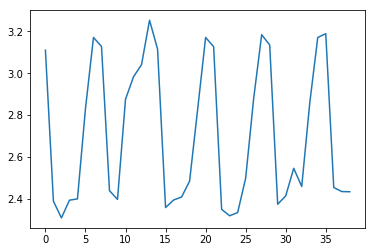

In [31]:
plt.plot(testpreds[129])

In [32]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [33]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.854407   
air_0164b9927d20bcc3_2017-04-23              1.479025   
air_0241aa3964b7f861_2017-04-23              2.343787   
air_0328696196e46f18_2017-04-23              2.123590   
air_034a3d5b40d5b1b1_2017-04-23              3.496694   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   5.387912  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.388663  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.420622  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.361100  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  32.006157

In [34]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [35]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [36]:
submission.to_csv("../submission/l3_3006_xgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')